# Imports

In [1]:
# Logging and warnings
import logging

# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm
import statsmodels.stats as st

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
# Set logging level for custom modules
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Set logging level for MNE
mne.set_log_level('WARNING')

In [5]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# MAIN

##### `Pre-Processing`

In [6]:
nirs_1 = NIRS(project='Multi-object Tracking').read(1, 2, 2, augment=True, transform=True, correction_factor=0.779)
nirs_2 = NIRS(project='Multi-object Tracking').read(1, 2, 3, augment=True, transform=True, correction_factor=0.779)

In [7]:
savepoints_1 = nirs_1.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=True, short_channel_regression=True, bandpass=True, negative_correlation_enhancement=False, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007, threshold_heart_rate=0.5)
savepoints_2 = nirs_2.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=True, short_channel_regression=True, bandpass=True, negative_correlation_enhancement=False, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007, threshold_heart_rate=0.5)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:621: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)
/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:621: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)


In [8]:
nirs_1.get_epochs(tmin=-5, tmax=15, baseline=(-0.1, 0))
nirs_2.get_epochs(tmin=-5, tmax=15, baseline=(-0.1, 0));

# Drop epochs where response was not correct
# nirs_1.epochs.drop(nirs_1.mat['id_correct'] != 1)
# nirs_2.epochs.drop(nirs_2.mat['id_correct'] != 1)

nirs_1.block_average();
nirs_2.block_average();

In [9]:
nirs = nirs_1 + nirs_2

In [10]:
raw_haemo = nirs.raw.copy().pick(nirs.good_ch_names)

In [11]:
# nirs.get_epochs(tmin=-5, # -(nirs.DUR['wait'])
#                 tmax=15, # (nirs.DUR['motion'] + nirs.DUR['probe'] + nirs.DUR['feedb'])
#                 baseline=(-0.1, 0));

# Drop epochs where response was not correct
nirs.epochs.drop(pd.concat(nirs.mat)['id_correct'] != 1);

nirs.block_average();

##### `GLM Analysis`

... GLM Analysis using inbuilt MNE functions ...
> Find significant channels and their 𝛽 values for the different load conditions

In [12]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                            drift_model=None, # 'cosine', 'polynomial'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

# design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [13]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)
glm_results = glm_est.to_dataframe()

In [14]:
glm_results['Significant'] = st.multitest.multipletests(glm_results['p_value'])[0]

In [15]:
glm_results_significant = glm_results.loc[glm_results['Significant']]
glm_results_significant[glm_results_significant['Condition'].isin(nirs.cases)]

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
3,4,6.0,2.314342e-14,9.449799e-05,1.757219e-07,-9.173828,-1.612042e-06,33,34,hbo,True,S33_D34 hbo
9,4,6.0,8.966093e-15,1.118754e-04,1.093739e-07,-8.903322,-9.737911e-07,33,34,hbr,True,S33_D34 hbr
12,0,6.0,1.941456e-13,1.487524e-04,5.137147e-07,-8.462610,-4.347367e-06,33,39,hbo,True,S33_D39 hbo
13,2,6.0,1.941456e-13,1.718369e-05,5.083996e-07,-12.350869,-6.279176e-06,33,39,hbo,True,S33_D39 hbo
15,4,6.0,1.941456e-13,2.535403e-06,5.089509e-07,-17.127534,-8.717074e-06,33,39,hbo,True,S33_D39 hbo
...,...,...,...,...,...,...,...,...,...,...,...,...
430,5,6.0,3.538320e-14,3.435049e-07,2.170424e-07,24.002678,5.209598e-06,44,39,hbr,True,S44_D39 hbr
441,4,6.0,2.067836e-15,1.051902e-05,5.252549e-08,-13.438224,-7.058493e-07,44,40,hbr,True,S44_D40 hbr
453,4,6.0,8.102433e-15,2.609875e-05,1.039728e-07,-11.490308,-1.194680e-06,44,41,hbr,True,S44_D41 hbr
459,4,6.0,1.618344e-14,1.541956e-05,1.469425e-07,-12.583519,-1.849054e-06,44,43,hbo,True,S44_D43 hbo


In [16]:
significant_channels = list(glm_results_significant[
    glm_results_significant['Condition'].isin(nirs.cases)
    # & (((glm_results_significant['Chroma'] == 'hbo') & (glm_results_significant['theta'] < 0))
    #  | ((glm_results_significant['Chroma'] == 'hbr') & (glm_results_significant['theta'] > 0)))
]['ch_name'].unique())

In [17]:
ips_channels_significant = list({f'{s_d} {ch_type}' 
                                 for s_d in utils.hex_to_dec([ # ['22', '28', '29', '2B']
                                     'S22_D28', 'S22_D29', 'S22_D2B', 'S28_D22', 'S28_D29', 'S28_D2B', 'S29_D28', 'S29_D2B', 'S2B_D22', 'S2B_D28', 'S2B_D29'])
                                 for ch_type in constants.HB_CHANNEL_TYPES
                                }.intersection(set(significant_channels)))

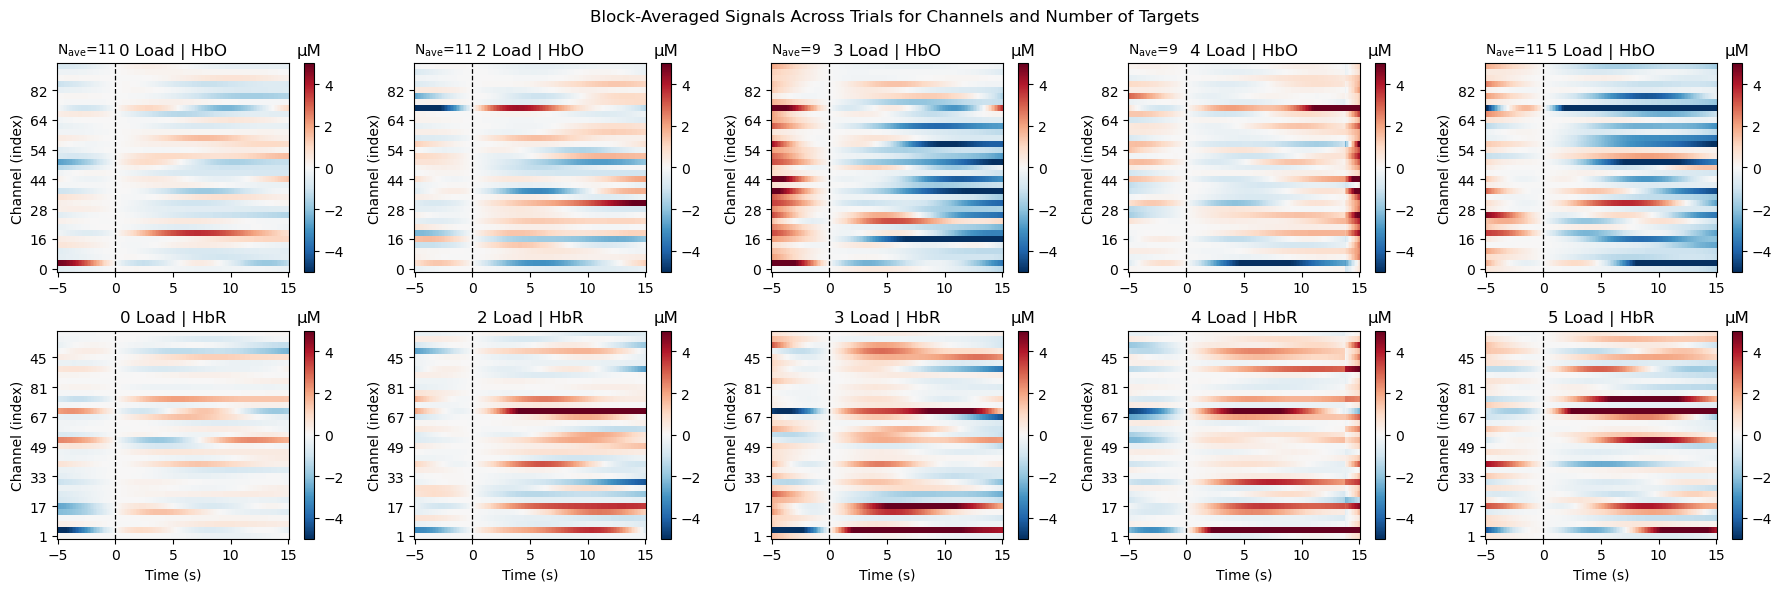

In [18]:
nirs.plot_average_heatmap(picks=significant_channels + utils.find_ch_pairs(nirs.raw.ch_names, significant_channels),
                          clim={'hbo': [-5, 5], 'hbr': [-5, 5]}).tight_layout()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot: xlabel='Condition', ylabel='Theta'>

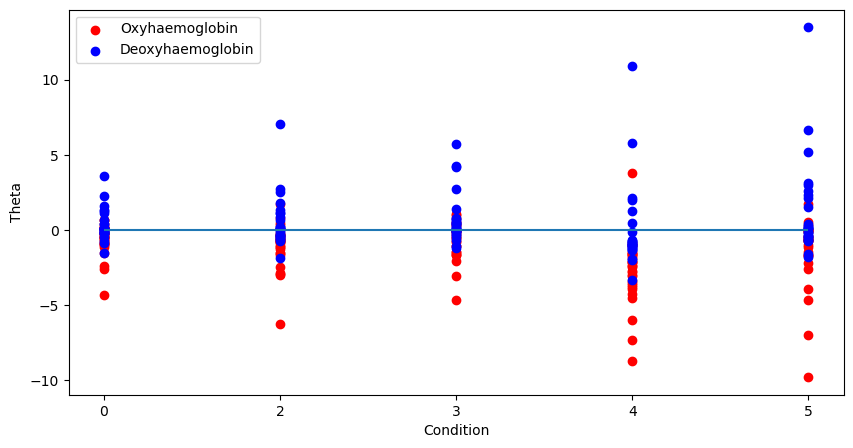

In [19]:
# fig, axs = plt.subplots(int(len(significant_channels)/5), 5, figsize=(20, 40))

# for ch, ax in zip(significant_channels, axs.ravel()):
#     glm_est.copy().pick(ch).scatter(axes=ax)
#     ax.set_title(ch)

# plt.tight_layout()

glm_est.copy().pick(significant_channels).scatter()

##### `Contrast Analysis`

> Compute and visualize constrasts between cases

##### `Plotting for GLM Analysis`

##### `Clustering`

> Relevant features  
>> For intervals of 1s in the epochs.  
>> - Area under the curve  
>> - Average slope  
>> - Maximum amplitude